# Assign 2 - Deep Learning
Jonathan Menahem - 203772611 <br>
Alon Mazri - 311503841

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import imagesize
import numpy as np
import seaborn as sns
from tensorflow import keras
from keras import layers
from sklearn.metrics import confusion_matrix
import tensorflow.keras.layers.experimental.preprocessing as preprocessing
import tensorflow as tf

In [2]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Loading The Data

In [3]:
image_size=(256, 256)
train_directory = 'chest_xray/train'
test_directory = 'chest_xray/test'
seed = np.random.randint(50, dtype=int)

# these are all default input values from documentation
train_data = tf.keras.utils.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=image_size,
    shuffle=True, seed=seed, validation_split=0.15, subset='training',
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=image_size, 
    shuffle=True, seed=seed, validation_split=0.15, subset='validation',
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)

# these are all default input values from documentation
test_data = tf.keras.utils.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=image_size,
    shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='bilinear', follow_links=False,
    crop_to_aspect_ratio=False
)

Found 5232 files belonging to 2 classes.
Using 4448 files for training.
Found 5232 files belonging to 2 classes.
Using 784 files for validation.
Found 624 files belonging to 2 classes.


In [4]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_train_ds = train_data.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = validation_data.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds = test_data.map(lambda x, y: (normalization_layer(x), y))

In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = normalized_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = normalized_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Transfer Learning
### resnet, densenet, inception, efficientnet

[Transfer Learning Tensorflow](https://www.tensorflow.org/tutorials/images/transfer_learning)

[Example using Resnet50](https://www.kaggle.com/abhishekdhule/pneumonia-detection-resnet-inception-tensorflow#Model-2-(ResNet-50))

[Example using Resnet50 #2](https://www.kaggle.com/satyaprakash13820/implementing-resnet-architecture)

### ResNet152 - Last Layer Training

In [ ]:
from tensorflow.keras.applications import ResNet152

num_classes = 2
input_shape = (256, 256, 3)

pretrained_resnet = ResNet152(include_top=False, input_tensor=None, input_shape=input_shape, pooling=None)

#freazing the trained layers
for layers in pretrained_resnet.layers:
    layers.trainable = False

pretrained_resnet.summary()

Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                          

In [ ]:
last_layer = pretrained_resnet.get_layer('conv5_block3_1_relu')
last_output = last_layer.output


x=tf.keras.layers.Flatten()(last_output)
x=tf.keras.layers.Dense(128, activation='relu')(x)
x=tf.keras.layers.Dropout(0.1)(x)
x=tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

resnet_model = tf.keras.Model(pretrained_resnet.input, x)

METRICS = ['accuracy']
 
resnet_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=METRICS)

resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
from keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.85
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr

In [ ]:
epochs = 20

learning_rate = LearningRateScheduler(lr_scheduler, verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

callbacks = [learning_rate, early_stopping]

resnet_history = resnet_model.fit(train_ds ,validation_data=val_ds ,epochs=epochs, callbacks=callbacks, verbose=2)


Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
139/139 - 32s - loss: 0.4475 - accuracy: 0.7842 - val_loss: 0.2949 - val_accuracy: 0.8852 - lr: 0.0010 - 32s/epoch - 231ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0008500000403728336.
Epoch 2/20
139/139 - 21s - loss: 0.2908 - accuracy: 0.8759 - val_loss: 0.2259 - val_accuracy: 0.9056 - lr: 8.5000e-04 - 21s/epoch - 150ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.0006141250501968897.
Epoch 3/20
139/139 - 21s - loss: 0.2269 - accuracy: 0.9087 - val_loss: 0.1999 - val_accuracy: 0.9069 - lr: 6.1413e-04 - 21s/epoch - 150ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.0003771495455584954.
Epoch 4/20
139/139 - 21s - loss: 0.1997 - accuracy: 0.9251 - val_loss: 0.1705 - val_accuracy: 0.9375 - lr: 3.7715e-04 - 21s/epoch - 150ms/step

Epoch 00005: LearningRateScheduler setting learning rate to 0.00019687442435679256.
Epoch 5/20


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


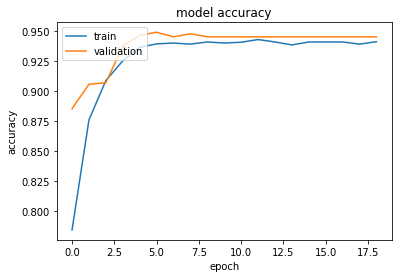

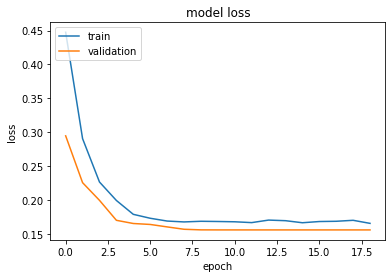

In [ ]:
# list all data in history
print(resnet_history.history.keys())
# summarize history for accuracy
plt.plot(resnet_history.history['accuracy'])
plt.plot(resnet_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(resnet_history.history['loss'])
plt.plot(resnet_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = resnet_model.evaluate(test_ds)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

20/20 [==============================] - 3s 123ms/step - loss: 0.6263 - accuracy: 0.7292
Test loss: 0.6263019442558289
Test accuracy: 0.7291666865348816


In [ ]:
# Get predictions and Original labels

predictions = np.array([])
test_labels =  np.array([])
for x, y in test_ds:
    predictions = np.concatenate([predictions, np.argmax(resnet_model.predict(x), axis = -1)])
    test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis=-1)])

print(test_labels.shape)
print(predictions.shape)

(624,)
(624,)


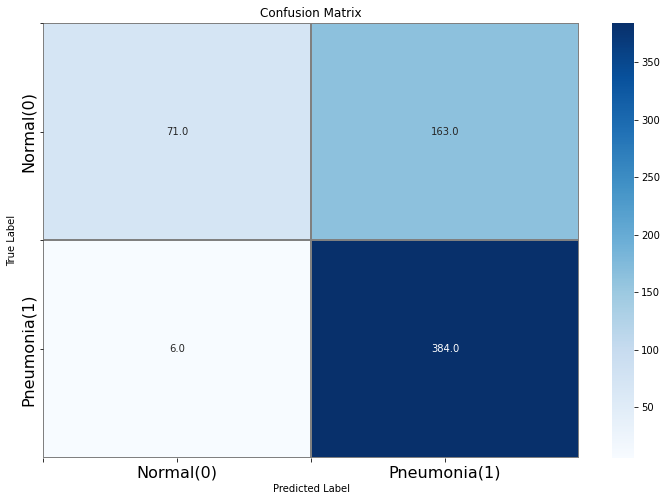

In [ ]:
# Get the confusion matrix
cm  = confusion_matrix(test_labels, predictions)
f,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap=plt.cm.Blues, linecolor="gray", fmt='.1f', ax=ax)
plt.xticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.yticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# prescision and recall calculation

from sklearn.metrics import classification_report
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

         0.0       0.92      0.30      0.46       234
         1.0       0.70      0.98      0.82       390

    accuracy                           0.73       624
   macro avg       0.81      0.64      0.64       624
weighted avg       0.78      0.73      0.68       624



### DenseNet - Last Layer Training

In [ ]:
from tensorflow.keras.applications import DenseNet121

num_classes = 2
input_shape = (256, 256, 3)

pretrained_densenet = DenseNet121(include_top=False, input_tensor=None, input_shape=input_shape, pooling=None)

#freazing the trained layers
for layers in pretrained_densenet.layers:
    layers.trainable = False

pretrained_densenet.summary()

29097984/29084464 [==============================] - 3s 0us/step
Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                       

In [ ]:
last_layer = pretrained_densenet.get_layer('conv5_block15_1_relu')
last_output = last_layer.output


x=tf.keras.layers.Flatten()(last_output)
x=tf.keras.layers.Dense(128, activation='relu')(x)
x=tf.keras.layers.Dropout(0.1)(x)
x=tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

densenet_model = tf.keras.Model(pretrained_densenet.input, x)

METRICS = ['accuracy']

densenet_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=METRICS)

densenet_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['input_2[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [ ]:
from keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.85
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr

In [ ]:
epochs = 20

learning_rate = LearningRateScheduler(lr_scheduler, verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

callbacks = [learning_rate, early_stopping]

densenet_history = densenet_model.fit(train_ds ,validation_data=val_ds ,epochs=epochs, callbacks=callbacks, verbose=2)


Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
139/139 - 27s - loss: 0.1711 - accuracy: 0.9400 - val_loss: 0.0752 - val_accuracy: 0.9745 - lr: 0.0010 - 27s/epoch - 198ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0008500000403728336.
Epoch 2/20
139/139 - 21s - loss: 0.0500 - accuracy: 0.9858 - val_loss: 0.0596 - val_accuracy: 0.9758 - lr: 8.5000e-04 - 21s/epoch - 150ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.0006141250501968897.
Epoch 3/20
139/139 - 24s - loss: 0.0286 - accuracy: 0.9928 - val_loss: 0.0556 - val_accuracy: 0.9770 - lr: 6.1413e-04 - 24s/epoch - 172ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.0003771495455584954.
Epoch 4/20
139/139 - 23s - loss: 0.0194 - accuracy: 0.9969 - val_loss: 0.0545 - val_accuracy: 0.9783 - lr: 3.7715e-04 - 23s/epoch - 162ms/step

Epoch 00005: LearningRateScheduler setting learning rate to 0.00019687442435679256.
Epoch 5/20


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


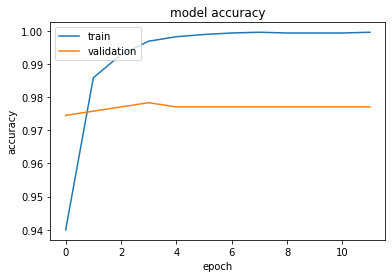

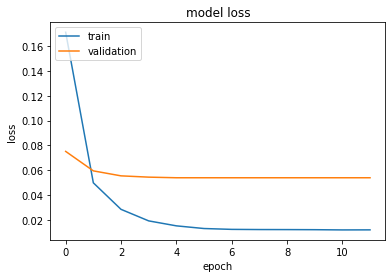

In [ ]:
# list all data in history
print(densenet_history.history.keys())
# summarize history for accuracy
plt.plot(densenet_history.history['accuracy'])
plt.plot(densenet_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(densenet_history.history['loss'])
plt.plot(densenet_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = densenet_model.evaluate(test_ds)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

20/20 [==============================] - 1s 60ms/step - loss: 0.7572 - accuracy: 0.7837
Test loss: 0.7571943402290344
Test accuracy: 0.7836538553237915


In [ ]:
# Get predictions and Original labels

predictions = np.array([])
test_labels =  np.array([])
for x, y in test_ds:
    predictions = np.concatenate([predictions, np.argmax(densenet_model.predict(x), axis = -1)])
    test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis=-1)])

print(test_labels.shape)
print(predictions.shape)

(624,)
(624,)


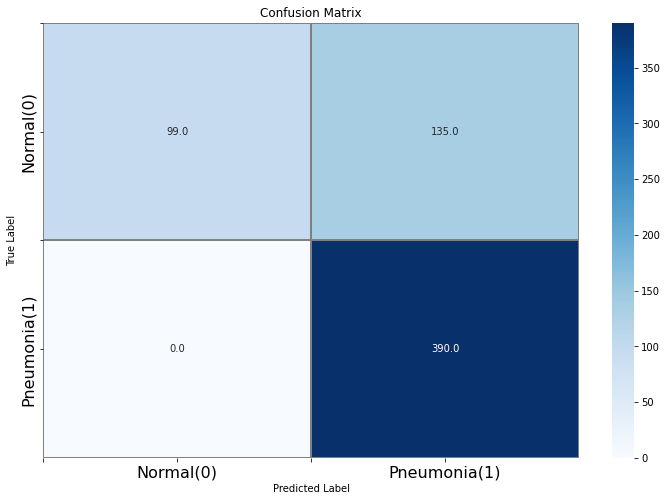

In [ ]:
# Get the confusion matrix
cm  = confusion_matrix(test_labels, predictions)
f,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap=plt.cm.Blues, linecolor="gray", fmt='.1f', ax=ax)
plt.xticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.yticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# prescision and recall calculation

from sklearn.metrics import classification_report
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

         0.0       1.00      0.42      0.59       234
         1.0       0.74      1.00      0.85       390

    accuracy                           0.78       624
   macro avg       0.87      0.71      0.72       624
weighted avg       0.84      0.78      0.76       624



###  Inception - Last Layer Training

In [ ]:
from tensorflow.keras.applications import InceptionV3

num_classes = 2
input_shape = (256, 256, 3)

pretrained_inception = InceptionV3(include_top=False, input_tensor=None, input_shape=input_shape, pooling=None)

#freazing the trained layers
for layers in pretrained_inception.layers:
    layers.trainable = False

last_layer_name = 'conv2d_86'
last_index = 0
idx = 0
for layer in pretrained_inception.layers:
    if layer.name == last_layer_name:
        last_index = idx
        print('end layer number', last_index)
    idx += 1

pretrained_inception.summary()

end layer number 283
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                 

In [ ]:
last_layer = pretrained_inception.get_layer(index=last_index)
last_output = last_layer.output


x=tf.keras.layers.Flatten()(last_output)
x=tf.keras.layers.Dense(128, activation='relu')(x)
x=tf.keras.layers.Dropout(0.1)(x)
x=tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

inception_model = tf.keras.Model(pretrained_inception.input, x)

METRICS = ['accuracy']

inception_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=METRICS)

inception_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
from keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.85
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr

In [ ]:
epochs = 20

learning_rate = LearningRateScheduler(lr_scheduler, verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

callbacks = [learning_rate, early_stopping]

inception_history = inception_model.fit(train_ds ,validation_data=val_ds ,epochs=epochs, callbacks=callbacks, verbose=2)


Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
139/139 - 15s - loss: 0.2310 - accuracy: 0.9272 - val_loss: 0.0820 - val_accuracy: 0.9643 - lr: 0.0010 - 15s/epoch - 108ms/step

Epoch 00002: LearningRateScheduler setting learning rate to 0.0008500000403728336.
Epoch 2/20
139/139 - 7s - loss: 0.0768 - accuracy: 0.9705 - val_loss: 0.0669 - val_accuracy: 0.9758 - lr: 8.5000e-04 - 7s/epoch - 47ms/step

Epoch 00003: LearningRateScheduler setting learning rate to 0.0006141250501968897.
Epoch 3/20
139/139 - 7s - loss: 0.0550 - accuracy: 0.9820 - val_loss: 0.0727 - val_accuracy: 0.9643 - lr: 6.1413e-04 - 7s/epoch - 48ms/step

Epoch 00004: LearningRateScheduler setting learning rate to 0.0003771495455584954.
Epoch 4/20
139/139 - 6s - loss: 0.0440 - accuracy: 0.9858 - val_loss: 0.0713 - val_accuracy: 0.9681 - lr: 3.7715e-04 - 6s/epoch - 46ms/step

Epoch 00005: LearningRateScheduler setting learning rate to 0.00019687442435679256.
Epoch 5/20
139/139 -

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


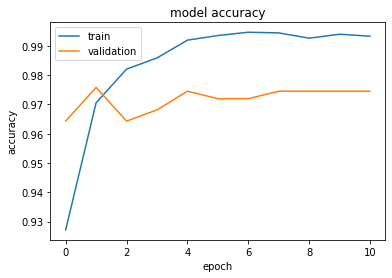

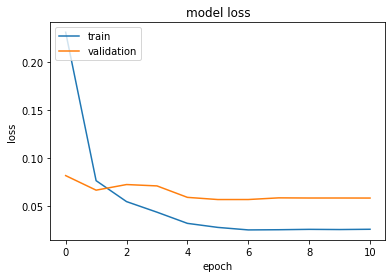

In [ ]:
# list all data in history
print(inception_history.history.keys())
# summarize history for accuracy
plt.plot(inception_history.history['accuracy'])
plt.plot(inception_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(inception_history.history['loss'])
plt.plot(inception_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = inception_model.evaluate(test_ds)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

20/20 [==============================] - 1s 47ms/step - loss: 0.7936 - accuracy: 0.7821
Test loss: 0.7936044931411743
Test accuracy: 0.7820512652397156


In [ ]:
# Get predictions and Original labels

predictions = np.array([])
test_labels =  np.array([])
for x, y in test_ds:
    predictions = np.concatenate([predictions, np.argmax(inception_model.predict(x), axis = -1)])
    test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis=-1)])

print(test_labels.shape)
print(predictions.shape)

(624,)
(624,)


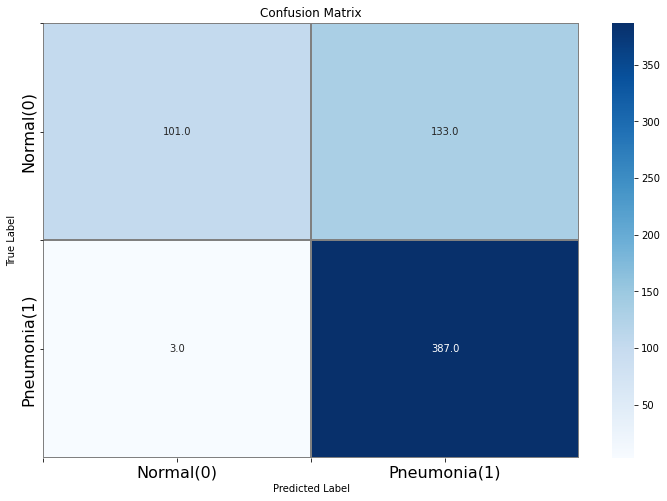

In [ ]:
# Get the confusion matrix
cm  = confusion_matrix(test_labels, predictions)
f,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap=plt.cm.Blues, linecolor="gray", fmt='.1f', ax=ax)
plt.xticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.yticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# prescision and recall calculation

from sklearn.metrics import classification_report
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

         0.0       0.97      0.43      0.60       234
         1.0       0.74      0.99      0.85       390

    accuracy                           0.78       624
   macro avg       0.86      0.71      0.72       624
weighted avg       0.83      0.78      0.76       624



###  Inception - Middle Layer Training

In [ ]:
from tensorflow.keras.applications import InceptionV3

num_classes = 2
input_shape = (256, 256, 3)

pretrained_inception_mid = InceptionV3(include_top=False, input_tensor=None, input_shape=input_shape, pooling=None)

pretrained_inception_mid.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
#freazing the trained layers
start_layer = 'conv2d_44'
end_layer = 'average_pooling2d_4'
last_layer_name = 'conv2d_86'
start_index = 0
end_index = 0
last_index = 0
idx = 0
for layer in pretrained_inception_mid.layers:
    if layer.name == start_layer:
        start_index = idx
        print('start layer number', start_index)
    if layer.name == end_layer:
        end_index = idx
        print('end layer number', end_index)
    if layer.name == last_layer_name:
        last_index = idx
        print('end layer number', last_index)
    idx += 1


start layer number 133
end layer number 151
end layer number 283


In [ ]:
#freazing the trained layers

for layer in pretrained_inception_mid.layers[:start_index]:
    layer.trainable=False
for layer in pretrained_inception_mid.layers[start_index:end_index]:
    layer.trainable=True
for layer in pretrained_inception_mid.layers[end_index:]:
    layer.trainable=False

In [ ]:
last_layer = pretrained_inception_mid.get_layer(index=last_index)
last_output = last_layer.output


x=tf.keras.layers.Flatten()(last_output)
x=tf.keras.layers.Dense(128, activation='relu')(x)
x=tf.keras.layers.Dropout(0.1)(x)
x=tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

inception_mid_model = tf.keras.Model(pretrained_inception_mid.input, x)

METRICS = ['accuracy']

inception_mid_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=METRICS)

inception_mid_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 127, 127, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 127, 127, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
from keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.85
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr

In [ ]:
epochs = 20

learning_rate = LearningRateScheduler(lr_scheduler, verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)

callbacks = [learning_rate, early_stopping]

inception_mid_history = inception_mid_model.fit(train_ds ,validation_data=val_ds ,epochs=epochs, callbacks=callbacks, class_weight=class_weight)


Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
139/139 [==============================] - 15s 105ms/step - loss: 0.1813 - accuracy: 0.9510 - val_loss: 0.0463 - val_accuracy: 0.9809 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0008500000403728336.
Epoch 2/20
139/139 [==============================] - 12s 85ms/step - loss: 0.0557 - accuracy: 0.9849 - val_loss: 0.1724 - val_accuracy: 0.9439 - lr: 8.5000e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.0006141250501968897.
Epoch 3/20
139/139 [==============================] - 12s 85ms/step - loss: 0.0221 - accuracy: 0.9921 - val_loss: 0.0490 - val_accuracy: 0.9847 - lr: 6.1413e-04

Epoch 00004: LearningRateScheduler setting learning rate to 0.0003771495455584954.
Epoch 4/20
139/139 [==============================] - 12s 86ms/step - loss: 0.0095 - accuracy: 0.9978 - val_loss: 0.0243 - val_accuracy: 0.9923 - lr: 3.7715e-04

Epoch 00005: LearningR

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


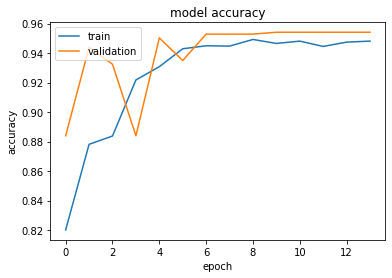

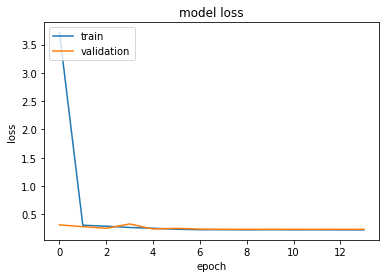

In [ ]:
# list all data in history
print(inception_mid_history.history.keys())
# summarize history for accuracy
plt.plot(inception_mid_history.history['accuracy'])
plt.plot(inception_mid_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(inception_mid_history.history['loss'])
plt.plot(inception_mid_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = inception_mid_model.evaluate(test_ds)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

20/20 [==============================] - 0s 5ms/step - loss: 0.7444 - accuracy: 0.7500
Test loss: 0.7444496750831604
Test accuracy: 0.75


In [ ]:
# Get predictions and Original labels

predictions = np.array([])
test_labels =  np.array([])
for x, y in test_ds:
    predictions = np.concatenate([predictions, np.argmax(inception_mid_model.predict(x), axis = -1)])
    test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis=-1)])

print(test_labels.shape)
print(predictions.shape)

(624,)
(624,)


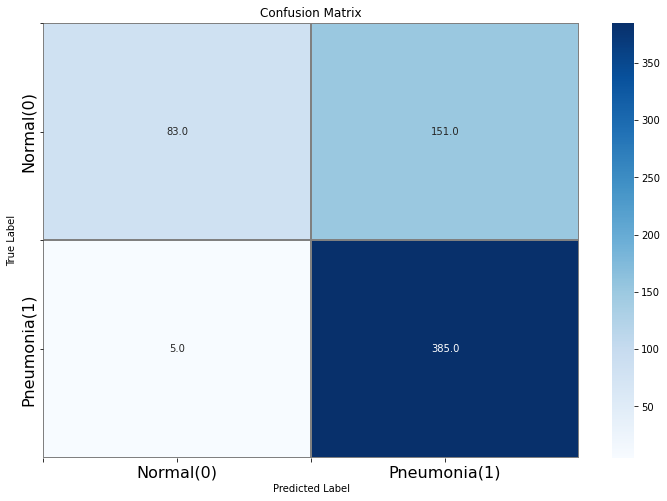

In [ ]:
# Get the confusion matrix
cm  = confusion_matrix(test_labels, predictions)
f,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap=plt.cm.Blues, linecolor="gray", fmt='.1f', ax=ax)
plt.xticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.yticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# prescision and recall calculation

from sklearn.metrics import classification_report
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

         0.0       0.94      0.35      0.52       234
         1.0       0.72      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.83      0.67      0.67       624
weighted avg       0.80      0.75      0.71       624



### Handeling Imbalanced Data - Class Weight

In [6]:
train_labels = np.array([])

for x, y in train_data:
    train_labels = np.concatenate([train_labels, np.argmax(y.numpy(), axis = -1)])

val_labels =  np.array([])

for x, y in validation_data:
    val_labels = np.concatenate([val_labels, np.argmax(y.numpy(), axis = -1)])

test_labels =  np.array([])

for x, y in test_data:
    test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis = -1)])


print("Train Labels Shape:", train_labels.shape)
print("Validation Labels Shape:", val_labels.shape)
print("Test Labels Shape:", test_labels.shape)

Train Labels Shape: (4448,)
Validation Labels Shape: (784,)
Test Labels Shape: (624,)


In [7]:
train_cases_count = np.unique(train_labels, return_counts=True)
val_cases_count = np.unique(val_labels, return_counts=True)
test_cases_count = np.unique(test_labels, return_counts=True)

total_cases_count = train_cases_count[1] + val_cases_count[1] + test_cases_count[1]

COUNT_NORMAL = total_cases_count[0]
COUNT_PNEUMONIA = total_cases_count[1]
TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA

In [8]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 1.85
Weight for class 1: 0.69


In [9]:
from tensorflow.keras.applications import ResNet50V2

num_classes = 2
input_shape = (256, 256, 3)

pretrained_resnet50V2 = ResNet50V2(include_top=False, input_tensor=None, input_shape=input_shape, pooling=None)

#freazing the trained layers
for layers in pretrained_resnet50V2.layers:
    layers.trainable = False

last_layer_name = 'conv5_block3_out'
last_index = 0
idx = 0
for layer in pretrained_resnet50V2.layers:
    if layer.name == last_layer_name:
        last_index = idx
        print('end layer number', last_index)
    idx += 1

pretrained_resnet50V2.summary()

end layer number 187
Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                    

In [10]:
last_layer = pretrained_resnet50V2.get_layer(index=last_index)
last_output = last_layer.output

x=tf.keras.layers.Dropout(0.15)(last_output)
x=tf.keras.layers.Flatten()(x)
x=tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

resnet50V2_model_CW = tf.keras.Model(pretrained_resnet50V2.input, x)

METRICS = ['accuracy']

resnet50V2_model_CW.compile(loss='binary_crossentropy', optimizer="adam", metrics=METRICS)

resnet50V2_model_CW.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [11]:
from keras.callbacks import LearningRateScheduler

# This is a sample of a scheduler I used in the past
def lr_scheduler(epoch, lr):
    decay_rate = 0.85
    decay_step = 1
    if epoch % decay_step == 0 and epoch:
        return lr * pow(decay_rate, np.floor(epoch / decay_step))
    return lr

In [12]:
epochs = 20

learning_rate = LearningRateScheduler(lr_scheduler, verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=False)

callbacks = [learning_rate, early_stopping]

resnet50V2_CW_history = resnet50V2_model_CW.fit(train_ds ,validation_data=val_ds ,epochs=epochs, callbacks=callbacks, class_weight=class_weight)


Epoch 00001: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/20
139/139 [==============================] - 14s 72ms/step - loss: 1.1787 - accuracy: 0.9353 - val_loss: 0.3299 - val_accuracy: 0.9719 - lr: 0.0010

Epoch 00002: LearningRateScheduler setting learning rate to 0.0008500000403728336.
Epoch 2/20
139/139 [==============================] - 8s 59ms/step - loss: 0.2268 - accuracy: 0.9773 - val_loss: 0.5267 - val_accuracy: 0.9579 - lr: 8.5000e-04

Epoch 00003: LearningRateScheduler setting learning rate to 0.0006141250501968897.
Epoch 3/20
139/139 [==============================] - 9s 62ms/step - loss: 0.2442 - accuracy: 0.9782 - val_loss: 0.1251 - val_accuracy: 0.9885 - lr: 6.1413e-04

Epoch 00004: LearningRateScheduler setting learning rate to 0.0003771495455584954.
Epoch 4/20
139/139 [==============================] - 9s 64ms/step - loss: 0.1131 - accuracy: 0.9876 - val_loss: 0.1398 - val_accuracy: 0.9847 - lr: 3.7715e-04

Epoch 00005: LearningRateS

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


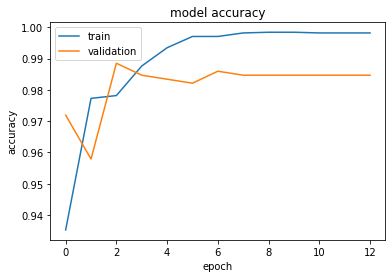

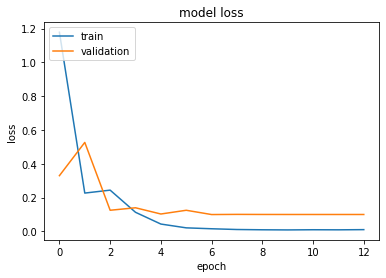

In [13]:
# list all data in history
print(resnet50V2_CW_history.history.keys())
# summarize history for accuracy
plt.plot(resnet50V2_CW_history.history['accuracy'])
plt.plot(resnet50V2_CW_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(resnet50V2_CW_history.history['loss'])
plt.plot(resnet50V2_CW_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
loss, accuracy = resnet50V2_model_CW.evaluate(test_ds)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

20/20 [==============================] - 1s 48ms/step - loss: 3.7228 - accuracy: 0.7981
Test loss: 3.72281551361084
Test accuracy: 0.7980769276618958


In [15]:
# Get predictions and Original labels

predictions = np.array([])
test_labels =  np.array([])
for x, y in test_ds:
    predictions = np.concatenate([predictions, np.argmax(resnet50V2_model_CW.predict(x), axis = -1)])
    test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis=-1)])

print(test_labels.shape)
print(predictions.shape)

(624,)
(624,)


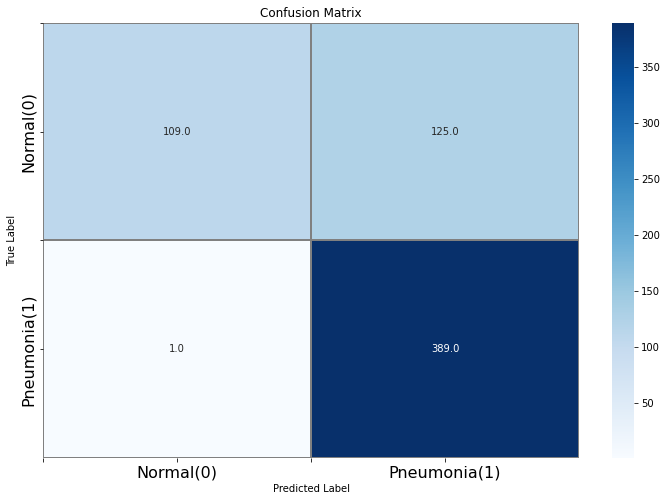

In [16]:
# Get the confusion matrix
cm  = confusion_matrix(test_labels, predictions)
f,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap=plt.cm.Blues, linecolor="gray", fmt='.1f', ax=ax)
plt.xticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.yticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [17]:
# prescision and recall calculation

from sklearn.metrics import classification_report
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

         0.0       0.99      0.47      0.63       234
         1.0       0.76      1.00      0.86       390

    accuracy                           0.80       624
   macro avg       0.87      0.73      0.75       624
weighted avg       0.84      0.80      0.78       624



### Handeling Imbalanced Data - Oversampling

[5 Techniques to Handle Imbalanced Data For a Classification Problem](https://www.analyticsvidhya.com/blog/2021/06/5-techniques-to-handle-imbalanced-data-for-a-classification-problem/)



In [7]:
import albumentations as A
import cv2
import os
from matplotlib import pyplot as plt

# Declare an augmentation pipeline
transform = A.Compose([
    A.CropAndPad(percent=-0.15, keep_size=False, sample_independently=True, interpolation=cv2.INTER_LANCZOS4, always_apply=False, p=0.5),
    A.Rotate(limit=18, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, brightness_by_max=True, always_apply=False, p=0.5),
    A.RandomScale(scale_limit=0.1, interpolation=1, always_apply=False, p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, interpolation=1, border_mode=4, always_apply=False, p=0.5),
    A.GaussNoise(var_limit=(10.0, 50.0), mean=0, per_channel=True, always_apply=False, p=0.5),
])


In [3]:
# # Read an image with OpenCV and convert it to the RGB colorspace

# train_NORMAL_directory = 'chest_xray/train/NORMAL'
# train_PNEUMONIA_directory = 'chest_xray/train/PNEUMONIA'
# train_NORMAL_aug = 'chest_xray/new_train/NORMAL_aug'
# train_PNEUMONIA_new = 'chest_xray/new_train/PNEUMONIA'
# val_NORMAL_directory = 'chest_xray/new_val/NORMAL'
# val_PNEUMONIA_directory = 'chest_xray/new_val/PNEUMONIA'

In [2]:
# # move a spcecific amout of files into validation directory
# # there is a total of 5232 images in training dir devided into 1349 NORMAL and 3883 PNEUMONIA
# # assuming we will end up with balanced data, 15% for validation will be 580 images
# # so, we will move 850 images from each category to another dir so that they wont be affected by the augmentation 

# # move images to validation dir under NORMAL label without change
# count = 0
# num_images = 580
# for filename in os.listdir(train_NORMAL_directory):
#     if filename.endswith(".jpeg"):
#         image = cv2.imread(train_NORMAL_directory + "/" + filename)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         cv2.imwrite(val_NORMAL_directory + "/" + filename, image)
#         try: 
#             os.remove(train_NORMAL_directory + "/" + filename)
#         except: pass
#         count += 1
#         if count == num_images:
#             break
#         continue
#     else:
#         continue

# # move images to validation dir under PNEUMONIA label without change
# count = 0
# num_images = 580
# for filename in os.listdir(train_PNEUMONIA_directory):
#     if filename.endswith(".jpeg"):
#         image = cv2.imread(train_PNEUMONIA_directory + "/" + filename)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         cv2.imwrite(val_PNEUMONIA_directory + "/" + filename, image)
#         try: 
#             os.remove(train_PNEUMONIA_directory + "/" + filename)
#         except: pass
#         count += 1
#         if count == num_images:
#             break
#         continue
#     else:
#         continue

# # copy images to train dir under PNEUMONIA label without change
# for filename in os.listdir(train_PNEUMONIA_directory):
#     if filename.endswith(".jpeg"):
#         image = cv2.imread(train_PNEUMONIA_directory + "/" + filename)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         cv2.imwrite(train_PNEUMONIA_new + "/" + filename, image)
#         continue
#     else:
#         continue

In [8]:
# # copy images to train dir under NORMAL label using 4 times random augmentations

# for i in range(4):
#     extention = "new" + str(i) + "_"
#     for filename in os.listdir(train_NORMAL_directory):
#         if filename.endswith(".jpeg"):
#             image = cv2.imread(train_NORMAL_directory + "/" + filename)
#             image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#             # Augment an image
#             transformed = transform(image=image)
#             transformed_image = transformed["image"]
#             cv2.imwrite(train_NORMAL_aug + "/" + extention + filename, transformed_image)
#             continue
#         else:
#             continue

In [2]:
image_size=(300, 300)
train_directory = 'chest_xray/new_train'
validation_directory = 'chest_xray/new_val'
test_directory = 'chest_xray/test'


# these are all default input values from documentation
train_data = tf.keras.utils.image_dataset_from_directory(
    train_directory, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=64, image_size=image_size,
    shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='lanczos5', follow_links=False,
    crop_to_aspect_ratio=False
)

validation_data = tf.keras.utils.image_dataset_from_directory(
    validation_directory, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=64, image_size=image_size, 
    shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='lanczos5', follow_links=False,
    crop_to_aspect_ratio=False
)

# these are all default input values from documentation
test_data = tf.keras.utils.image_dataset_from_directory(
    test_directory, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=64, image_size=image_size,
    shuffle=True, seed=None, validation_split=None, subset=None,
    interpolation='lanczos5', follow_links=False,
    crop_to_aspect_ratio=False
)

Found 6379 files belonging to 2 classes.
Found 1160 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [3]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_train_ds = train_data.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = validation_data.map(lambda x, y: (normalization_layer(x), y))
normalized_test_ds = test_data.map(lambda x, y: (normalization_layer(x), y))

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = normalized_train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = normalized_val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = normalized_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [5]:
train_labels = np.array([])

for x, y in train_data:
    train_labels = np.concatenate([train_labels, np.argmax(y.numpy(), axis = -1)])

print("Train Labels Shape:", train_labels.shape)

Train Labels Shape: (6379,)


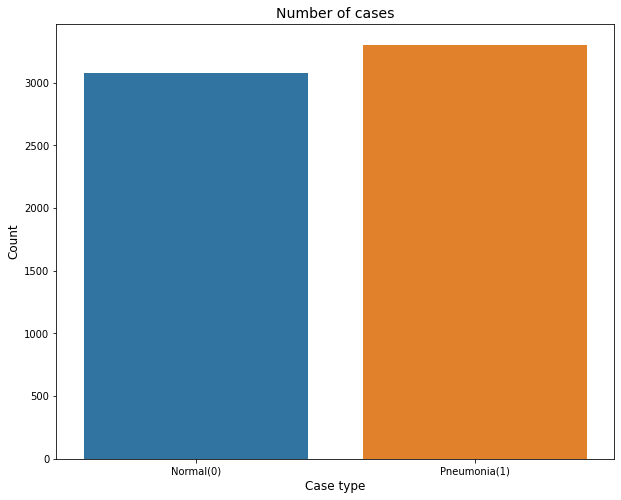

In [6]:
train_cases_count = np.unique(train_labels, return_counts=True)

# Plot the results 
plt.figure(figsize=(10,8))
sns.barplot(x=[0, 1], y=train_cases_count[1])
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(train_cases_count[1])), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

In [7]:
from tensorflow.keras.applications import InceptionV3

num_classes = 2
input_shape = (300, 300, 3)

pretrained_inception_mid_imb = InceptionV3(include_top=False, input_tensor=None, input_shape=input_shape, pooling=None)

pretrained_inception_mid_imb.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [8]:
#freazing the trained layers
start_layer = 'conv2d_44'
end_layer = 'average_pooling2d_4'
last_layer_name = 'conv2d_86'
start_index = 0
end_index = 0
last_index = 0
idx = 0
for layer in pretrained_inception_mid_imb.layers:
    if layer.name == start_layer:
        start_index = idx
        print('start layer number', start_index)
    if layer.name == end_layer:
        end_index = idx
        print('end layer number', end_index)
    if layer.name == last_layer_name:
        last_index = idx
        print('end layer number', last_index)
    idx += 1


start layer number 133
end layer number 151
end layer number 283


In [9]:
#freazing the trained layers

for layer in pretrained_inception_mid_imb.layers[:start_index]:
    layer.trainable=False
for layer in pretrained_inception_mid_imb.layers[start_index:end_index]:
    layer.trainable=True
for layer in pretrained_inception_mid_imb.layers[end_index:]:
    layer.trainable=False

In [10]:
last_layer = pretrained_inception_mid_imb.get_layer(index=last_index)
last_output = last_layer.output

x=tf.keras.layers.Flatten()(last_output)
x=tf.keras.layers.Dense(128, activation='relu')(x)
x=tf.keras.layers.Dropout(0.1)(x)
x=tf.keras.layers.Dense(num_classes, activation='sigmoid')(x)

inception_mid_imb_model = tf.keras.Model(pretrained_inception_mid_imb.input, x)

METRICS = ['accuracy']

inception_mid_imb_model.compile(loss='binary_crossentropy', optimizer="adam", metrics=METRICS)

inception_mid_imb_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 149, 149, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 149, 149, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [11]:
EPOCHS = 30

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=False)

callbacks = [early_stopping]

inception_mid_imb_history = inception_mid_imb_model.fit(train_ds ,validation_data=val_ds ,epochs=EPOCHS, callbacks=callbacks)

Epoch 1/30
100/100 [==============================] - 31s 229ms/step - loss: 0.3179 - accuracy: 0.9172 - val_loss: 0.1070 - val_accuracy: 0.9629
Epoch 2/30
100/100 [==============================] - 18s 176ms/step - loss: 0.0250 - accuracy: 0.9923 - val_loss: 0.0586 - val_accuracy: 0.9810
Epoch 3/30
100/100 [==============================] - 17s 174ms/step - loss: 0.0152 - accuracy: 0.9950 - val_loss: 0.1357 - val_accuracy: 0.9517
Epoch 4/30
100/100 [==============================] - 16s 165ms/step - loss: 0.0098 - accuracy: 0.9966 - val_loss: 0.0716 - val_accuracy: 0.9750
Epoch 5/30
100/100 [==============================] - 16s 163ms/step - loss: 0.0092 - accuracy: 0.9966 - val_loss: 0.0562 - val_accuracy: 0.9819
Epoch 6/30
100/100 [==============================] - 16s 163ms/step - loss: 0.0062 - accuracy: 0.9981 - val_loss: 0.0744 - val_accuracy: 0.9828
Epoch 7/30
100/100 [==============================] - 17s 167ms/step - loss: 0.0073 - accuracy: 0.9978 - val_loss: 0.0496 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


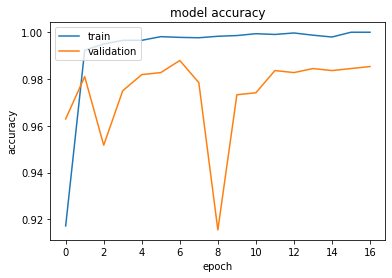

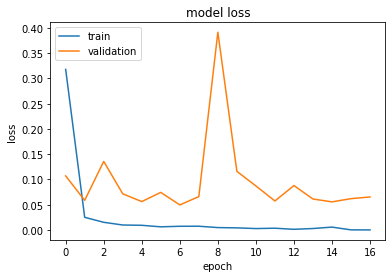

In [12]:
# list all data in history
print(inception_mid_imb_history.history.keys())
# summarize history for accuracy
plt.plot(inception_mid_imb_history.history['accuracy'])
plt.plot(inception_mid_imb_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(inception_mid_imb_history.history['loss'])
plt.plot(inception_mid_imb_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [13]:
loss, accuracy = inception_mid_imb_model.evaluate(test_ds)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

10/10 [==============================] - 3s 207ms/step - loss: 1.7326 - accuracy: 0.8109
Test loss: 1.7325644493103027
Test accuracy: 0.8108974099159241


In [14]:
# Get predictions and Original labels

predictions = np.array([])
test_labels =  np.array([])
for x, y in test_ds:
    predictions = np.concatenate([predictions, np.argmax(inception_mid_imb_model.predict(x), axis = -1)])
    test_labels = np.concatenate([test_labels, np.argmax(y.numpy(), axis=-1)])

print(test_labels.shape)
print(predictions.shape)

(624,)
(624,)


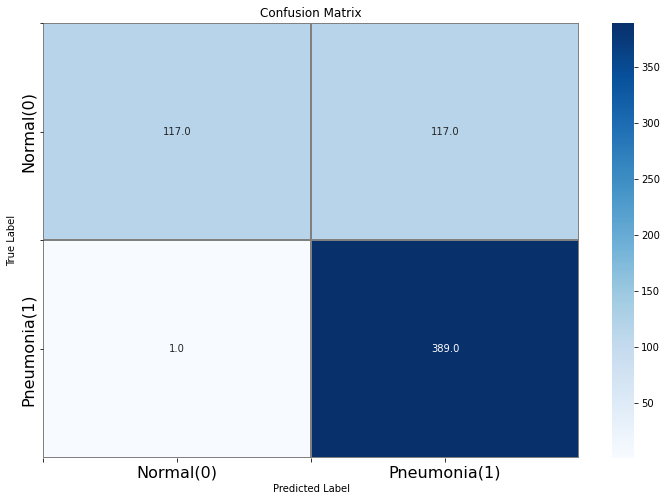

In [15]:
# Get the confusion matrix
cm  = confusion_matrix(test_labels, predictions)
f,ax = plt.subplots(figsize=(12, 8))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap=plt.cm.Blues, linecolor="gray", fmt='.1f', ax=ax)
plt.xticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.yticks(np.arange(0, 2, step=0.5), ['', 'Normal(0)', '', 'Pneumonia(1)'], fontsize=16)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [16]:
# prescision and recall calculation

from sklearn.metrics import classification_report
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

         0.0       0.99      0.50      0.66       234
         1.0       0.77      1.00      0.87       390

    accuracy                           0.81       624
   macro avg       0.88      0.75      0.77       624
weighted avg       0.85      0.81      0.79       624

